# Data simulation

For chapter 2, we create several simulated data sets to work with.

What we are interested in looking at:
- Standard Weibull case with a linear predictor;
- Weibull with non-linear predictor;
- Presence of a large number of covariates;
- Non proportional hazards.

TODO: What about categorical data?

Function that randomly censors data:

In [3]:
def random_rcensor(df,censor_prop,max_time):
    df = df.assign(
        y_censor = lambda dataframe: dataframe['y'].map(lambda y: min(np.random.uniform(high = max_time),y) if bernoulli.rvs(censor_prop) else min(y,max_time)),
        event = lambda dataframe: dataframe['y'] == dataframe['y_censor']
    )
    return(df)

## Weibull distribution, simple linear predictor

In [4]:
import numpy as np
from scipy.stats import weibull_min # r weibull simulation
from scipy.stats import norm # for covariate simulation
from scipy.stats import gamma # for weibull shape parameter
from scipy.stats import bernoulli # for censoring
import pandas as pd

$\beta \sim \mathcal{N}_{n_\beta}(0,\sigma)$, $x_i \sim \mathcal{N}_{n_\beta}(0,1)$, $y_i \sim \text{Weib}(c,\exp(x_i ^T \beta/c))$, $c \sim \Gamma(1)$.

In [10]:
def weibull_simple_linear_sim(n_beta,sigma,obs, censor_prop,max_time, show_beta = False):
    betas = norm.rvs(scale = sigma, size = n_beta) #generates the coefficients
    X = norm.rvs(size = obs*n_beta).reshape((obs,n_beta)) # matrix of covariates
    
    c = gamma.rvs(1) # shape parameter of weibull
    
    lin_pred = np.matmul(X,betas) # linear predictor
    
    sim_data = pd.DataFrame(X)
    sim_data["y"] = weibull_min.rvs(c, scale = np.exp(-lin_pred/c))
    
    if show_beta:
        return(betas,random_rcensor(sim_data,censor_prop,max_time))
    else:
        return(random_rcensor(sim_data,censor_prop,max_time))

In [11]:
test = weibull_simple_linear_sim(4,2,10,0.2,5)
test

,0,1,2,3,y,y_censor,event
0,1.032808,-0.215123,1.484464,-1.167771,3.100964e-04,3.100964e-04,True
1,-0.650445,1.545760,-0.726359,-0.190645,6.056390e-08,6.056390e-08,True
2,1.186039,-1.324388,0.438564,-0.106337,2.389100e+07,5.000000e+00,False
3,-1.418396,-0.464581,-0.190523,1.570762,1.638154e-01,1.638154e-01,True
4,1.363663,-1.565784,-1.267813,-0.224696,3.915251e+05,5.000000e+00,False
5,0.899866,-0.247199,-0.127167,0.870932,6.005204e+07,5.000000e+00,False
6,-0.291205,1.110989,0.409921,-0.815465,1.689636e-08,1.689636e-08,True
7,-1.060606,-0.013390,0.495953,-0.604197,2.000945e-06,2.000945e-06,True
8,0.640547,-1.277792,-0.167663,0.971488,3.310770e+08,5.000000e+00,False
9,0.687676,0.023675,1.445340,0.258628,3.951057e-02,3.951057e-02,True


## Weibull with a non-linear predictor

$\beta \in \mathbb{R}^{n_\beta}$ chosen, $x_i \sim \mathcal{N}_{n_\beta}(0,1)$, $\alpha \in \mathbb{R}^{n_\beta}$ chosen, $y_i \sim \text{Weib}(1,\exp(x_i^{\alpha \, T} \beta))$, where exponentiation is element wise.

In [109]:
def weibull_nonlinear_sim(betas,alpha,obs,censor_prop,max_time):
    n_beta = len(betas)
    X = norm.rvs(size = obs*n_beta).reshape((obs,n_beta)) # matrix of covariates
    for j in range(n_beta):
        X[:,j] = X[:,j]**alpha[j]
        
    lin_pred = np.matmul(X,betas) # linear predictor
    
    sim_data = pd.DataFrame(X)
    sim_data["y"] = weibull_min.rvs(1, scale = np.exp(-lin_pred))
    
    return(random_rcensor(sim_data,censor_prop,max_time))

In [111]:
weibull_nonlinear_sim([1,1],[1,2],3,0.2,0.1)

,0,1,y
0,-0.814376,2.230313,0.100000
1,0.196519,0.004909,0.018271
2,1.324537,2.857753,0.026927


## Large number of variables

Function simulates when some variables are uncorrelated. $n_\text{uncorr}$ are uniformly sampled to be uncorrelated.

In [112]:
def weibull_uncorr(n_beta,sigma,obs,n_uncorr,censor_prop,max_time, show_beta = False):
    betas = norm.rvs(scale = sigma, size = n_beta) #generates the coefficients
    X = norm.rvs(size = obs*n_beta).reshape((obs,n_beta)) # matrix of covariates
    X_uncorr = norm.rvs(size = obs*n_uncorr).reshape((obs,n_uncorr)) # matrix of covariates
    
    c = gamma.rvs(1) # shape parameter of weibull
    
    lin_pred = np.matmul(X,betas) # linear predictor
    
    sim_data = pd.DataFrame(np.hstack([X,X_uncorr]))
    sim_data["y"] = weibull_min.rvs(c, scale = np.exp(-lin_pred/c))
    
    if show_beta:
        return(betas,random_rcensor(sim_data,censor_prop,max_time))
    else:
        return(random_rcensor(sim_data,censor_prop,max_time))

In [113]:
weibull_uncorr(4,2,10,2,0.2,5)

,0,1,2,3,4,5,y
0,0.788225,-0.345877,-1.082293,1.091796,0.460083,1.967478,0.000397
1,-0.085059,-0.084488,-1.469917,0.416570,0.268900,-1.194977,0.043982
2,-0.309595,-0.523254,0.735455,0.099029,-1.619650,0.944160,0.034496
3,1.158767,-0.999824,0.303063,-0.816330,-1.272555,-0.518832,5.000000
4,-0.802824,-0.051375,-0.693621,-0.566281,-0.823778,0.556847,5.000000
5,1.201732,1.028045,0.936159,-1.560390,-0.706600,0.298573,5.000000
6,-0.060407,-0.932366,0.133205,0.360475,0.206418,-1.902259,0.069761
7,0.196494,0.477740,0.036735,0.578789,0.564374,-0.029014,0.138680
8,-0.975103,-0.421959,1.179760,0.063623,0.389991,2.140401,2.882438
9,0.944161,0.362395,0.592440,0.510850,1.280452,-1.580214,0.008508


## Non-proportional hazards

Accelerated falure models takethe form
\begin{align}
\log T = X^T \beta + \sigma W.
\end{align}
The function allows specification of what W you want to use.

In [118]:
def AFM_sim(n_beta,sigma,obs,n_uncorr, dist,censor_prop,max_time, show_beta = False):
    betas = norm.rvs(scale = sigma, size = n_beta) #generates the coefficients
    X = norm.rvs(size = obs*n_beta).reshape((obs,n_beta)) # matrix of covariates
    X_uncorr = norm.rvs(size = obs*n_uncorr).reshape((obs,n_uncorr)) # matrix of covariates

    w = norm.rvs(size = obs) # random errors
    
    lin_pred = np.matmul(X,betas) # linear predictor

    sim_data = pd.DataFrame(np.hstack([X,X_uncorr]))
    sim_data["y"] = np.exp(dist.rvs(size = obs, loc = lin_pred)*sigma)
    
    if show_beta:
        return(betas,random_rcensor(sim_data,censor_prop,max_time))
    else:
        return(random_rcensor(sim_data,censor_prop,max_time))

In [119]:
AFM_sim(4,2,10,2,norm,0.2,5)

,0,1,2,3,4,5,y
0,0.941196,0.420040,-0.655866,-1.129472,0.850685,0.167535,5.000000e+00
1,0.645350,0.376786,0.647655,-0.343751,-0.587702,-0.453165,8.505475e-01
2,0.220594,-0.613779,-0.725526,-0.454240,0.168992,-0.667601,5.000000e+00
3,0.970374,0.584082,-0.020037,-0.731265,0.114094,-0.899895,8.731466e-01
4,0.972824,0.715781,-1.443813,0.846640,1.253749,1.331694,5.708049e-10
5,-0.460240,-0.840835,-0.669755,-0.793512,0.419683,-1.338604,3.308020e+00
6,-0.749597,0.635178,-2.011780,0.055785,-1.121808,0.761355,4.240015e-04
7,0.389200,-0.563434,-2.347315,-0.915905,-0.111224,-0.225412,5.000000e+00
8,-0.981310,-0.495578,-1.640732,1.664222,-0.998642,0.040669,1.891395e-06
9,-1.135952,0.628192,0.083116,-0.500627,-0.333166,0.649962,5.000000e+00


# Checking the models via graphs

In [122]:
import matplotlib.pyplot as plt
import numpy as np

In [157]:
test = weibull_simple_linear_sim(4,0.1,1000,0.2,1)
test

,0,1,2,3,y,y_censor
0,-0.554818,-1.017595,-1.662427,-0.959596,1.977086e-55,1.977086e-55
1,0.649750,-0.233511,-0.815004,-2.550354,9.736043e-04,9.736043e-04
2,0.842169,1.023340,0.266277,1.296857,2.550958e+34,1.000000e+00
3,-1.031696,0.361867,1.312949,0.490910,1.827208e-50,1.827208e-50
4,-0.037968,-0.847734,0.491309,-0.341115,2.731958e-31,2.731958e-31
...,...,...,...,...,...,...
995,0.948933,0.332848,-1.473826,-0.062670,6.205956e-23,6.205956e-23
996,-0.145572,-1.279571,-0.846143,-0.468764,1.029421e+118,1.000000e+00
997,1.240188,-0.950525,0.836564,0.489818,2.446774e+00,1.000000e+00
998,-0.195107,0.352035,0.263743,0.451482,1.310862e+19,1.000000e+00


(array([ 19.,  31.,  27.,  23.,  26.,  23.,  20.,  20.,  19.,  13.,  28.,
          9.,  18.,  28.,  13.,  18.,  13.,   9.,  13.,  16.,  13.,  14.,
         17.,  15.,  10.,  11.,   9.,  10.,  14.,  10.,   5.,  17.,  10.,
         17.,  12.,  12.,  12.,   9.,  10.,  11.,   8.,   6.,  11.,  10.,
          8.,   7.,   8.,   9.,   5., 304.]),
 array([0.00206933, 0.02202795, 0.04198656, 0.06194517, 0.08190379,
        0.1018624 , 0.12182101, 0.14177963, 0.16173824, 0.18169685,
        0.20165547, 0.22161408, 0.24157269, 0.26153131, 0.28148992,
        0.30144853, 0.32140715, 0.34136576, 0.36132437, 0.38128299,
        0.4012416 , 0.42120021, 0.44115883, 0.46111744, 0.48107605,
        0.50103467, 0.52099328, 0.54095189, 0.56091051, 0.58086912,
        0.60082773, 0.62078635, 0.64074496, 0.66070357, 0.68066219,
        0.7006208 , 0.72057941, 0.74053803, 0.76049664, 0.78045525,
        0.80041387, 0.82037248, 0.84033109, 0.86028971, 0.88024832,
        0.90020693, 0.92016555, 0.94012416, 0.

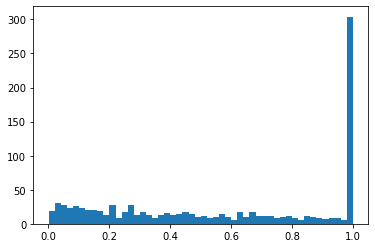

In [144]:
plt.hist(test['y'],bins = 50)